In [1]:
import phyflow as pf
import phyflow.monte_carlo as mc
import phyflow.phy_flow_matching as pfm
from pathlib import Path
import torch
from torchvision.transforms.v2 import Compose, RandomHorizontalFlip, RandomVerticalFlip, Resize, RandomCrop
from torch.utils.data import ConcatDataset, DataLoader
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
import matplotlib.pyplot as plt

In [2]:
trash = []

# Increase Sample Density Lab

### Prepare the Monte Carlo data of the XY model

In [3]:
save_dir_root = './'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
xy_generator = mc.MCDataGenerator(sampler_class=mc.XYModel, save_dir_root=save_dir_root)

L = 24
T_start = 0.1
T_end = 2.0
precision = 0.05
ensemble_number = 1000

2025-06-23 17:50:15,178 - INFO - MCDataGenerator initialized for XYModel with save root: .


In [4]:
xy_generator.forward(
    L=L,
    T_start=T_start,
    T_end=T_end,
    precision=precision,
    ensemble_number=ensemble_number,
    device=device,
)
trash.append(xy_generator)

2025-06-23 17:50:15,334 - INFO - --- Simulation Parameters for XYModel ---
2025-06-23 17:50:15,335 - INFO - Lattice size (L): 24
2025-06-23 17:50:15,335 - INFO - Temperature range: 0.1 to 2.0 (precision: 0.05, steps: 38)
2025-06-23 17:50:15,336 - INFO - Device: cuda:0
2025-06-23 17:50:15,336 - INFO - Ensemble number per T: 1000
2025-06-23 17:50:15,336 - INFO - Number of chains (n_chains): 30
2025-06-23 17:50:15,337 - INFO - Parallel Tempering: Enabled (interval: 1, prob: 0.1)
2025-06-23 17:50:15,337 - INFO - Calculated tau: 576.0, tau_eff: 9.8
2025-06-23 17:50:15,338 - INFO - Thermalization sweeps (n_therm): 14400 (factor: 25)
2025-06-23 17:50:15,338 - INFO - Decorrelation sweeps (decorrelate): 19 (factor: 2)
2025-06-23 17:50:15,338 - INFO - Production sweeps (n_sweeps): 627
2025-06-23 17:50:15,339 - INFO - -----------------------------------------------------


Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=38, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


2025-06-23 17:50:15,392 - INFO - Starting Monte Carlo simulation...


Starting simulation: 14400 thermalization sweeps, 627 production sweeps.
Thermalization phase...
Production phase...


2025-06-23 17:50:55,753 - INFO - Simulation finished. Elapsed time: 40.36 s
2025-06-23 17:50:55,753 - INFO - Generated samples shape: torch.Size([38, 990, 24, 24])
2025-06-23 17:50:55,754 - INFO - Ensured directory exists: mc_data
2025-06-23 17:50:55,755 - INFO - Ensured directory exists: mc_data\XYModel
2025-06-23 17:50:55,755 - INFO - Ensured directory exists: mc_data\XYModel\field_config
2025-06-23 17:50:55,756 - INFO - Ensured directory exists: mc_data\XYModel\measurement
2025-06-23 17:50:55,757 - INFO - Saving field configurations to: mc_data\XYModel\field_config\XYModel_L24_T0_100-2_000_prec0_050_ens1000_configs.pt
2025-06-23 17:50:55,757 - INFO - Configs tensor shape: torch.Size([38, 990, 24, 24])
2025-06-23 17:50:55,758 - INFO - Labels tensor shape: torch.Size([38, 2])


Simulation finished. Collected 990 samples.
labels shape: torch.Size([38, 2])
first label pair: tensor([ 0.1000, 24.0000])


2025-06-23 17:50:56,294 - INFO - Field configurations saved.
2025-06-23 17:50:56,294 - INFO - Performing measurements...
2025-06-23 17:50:56,966 - INFO - Measurements complete.
2025-06-23 17:50:56,967 - INFO - Saving measurements dictionary to: mc_data\XYModel\measurement\XYModel_L24_T0_100-2_000_prec0_050_ens1000_measurements.pt
2025-06-23 17:50:57,003 - INFO - Measurements dictionary saved.
2025-06-23 17:50:57,003 - INFO - Saving plots to: mc_data\XYModel\measurement\XYModel_L24_T0_100-2_000_prec0_050_ens1000_plots.png
2025-06-23 17:50:58,385 - INFO - Plots saved.
2025-06-23 17:50:58,511 - INFO - Cleared CUDA cache.
2025-06-23 17:50:58,511 - INFO - MCDataGenerator call finished. Total time: 43.30 s


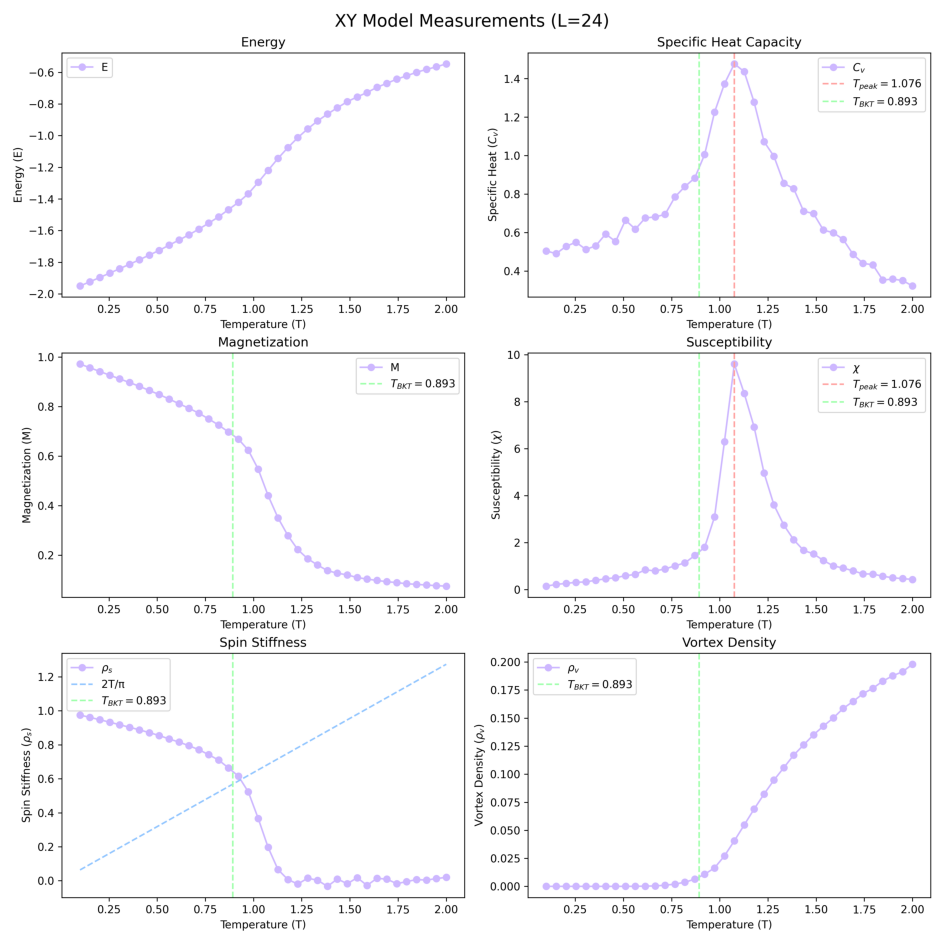

In [5]:
save_dir_root = Path(save_dir_root)
sampler_name = mc.XYModel.__name__
mc_data_dir = save_dir_root / "mc_data"
sampler_dir = mc_data_dir / sampler_name
field_config_dir = sampler_dir / "field_config"
filename_base = f"{sampler_name}_L{L}_T{T_start:.3f}-{T_end:.3f}_prec{precision:.3f}_ens{ensemble_number}"
filename_base = filename_base.replace('.', '_')
config_save_path = field_config_dir / f"{filename_base}_configs.pt"

mc_config_results = torch.load(config_save_path, map_location='cpu', weights_only=False)

measurement_dir = sampler_dir / "measurement"
measurement_save_path_pt = measurement_dir / f"{filename_base}_measurements.pt"

mc_measure_results = torch.load(measurement_save_path_pt, map_location='cpu', weights_only=False)

measurement_save_path_png = measurement_dir / f"{filename_base}_plots.png"
img = pf.load_image_pil(measurement_save_path_png)

pf.display_image_pil(img, figsize=(12, 12))

In [6]:
mc_config_results.keys()

dict_keys(['configs', 'labels', 'spend_time', 'params'])

In [7]:
xy_spin_config = mc_config_results['configs']
labels = mc_config_results['labels']
T = torch.linspace(T_start, T_end, int((T_end - T_start) // precision) + 1, device=device)

xy_spin_config.shape

torch.Size([38, 990, 24, 24])

In [8]:
trash.append(mc_config_results)
pf.clear_cuda_cache(trash)
trash = []

### Prepare the dataset

In [9]:
t_focus_start_1 = 0.0
t_focus_end_1 = 1.0
t_focus_start_index_1 = len(T[T <= t_focus_start_1])
t_focus_end_index_1 = len(T[T <= t_focus_end_1])

In [10]:
labels_selected = labels[:, 0]

transform_flip = Compose([
    RandomHorizontalFlip(p=0.8),
    RandomVerticalFlip(p=0.8),
])

transform_roll = Compose([
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
])

transform_flip_roll = Compose([
    RandomHorizontalFlip(p=0.7),
    RandomVerticalFlip(p=0.7),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
])

xy_dataset_raw = mc.MCDataset(
    data=xy_spin_config,
    labels=labels_selected,
)

xy_dataset_transform_1 = mc.MCDataset(
    data=xy_spin_config,
    labels=labels_selected,
    transform=transform_flip,
)

xy_dataset_focus_1_transform_1 = mc.MCDataset(
    data=xy_spin_config[t_focus_start_index_1:t_focus_end_index_1, ...], 
    labels=labels_selected[t_focus_start_index_1:t_focus_end_index_1, ...],
    transform=transform_roll,
)

xy_dataset_focus_1_transform_2 = mc.MCDataset(
    data=xy_spin_config[t_focus_start_index_1:t_focus_end_index_1, ...], 
    labels=labels_selected[t_focus_start_index_1:t_focus_end_index_1, ...],
    transform=transform_flip_roll,
)

xy_dataset = ConcatDataset([
    xy_dataset_raw,
    xy_dataset_transform_1,
])

xy_dataset_focus_1 = ConcatDataset([
    xy_dataset_focus_1_transform_1,
    xy_dataset_focus_1_transform_2,
])

batch_size = 32

xy_dataloader = DataLoader(xy_dataset, batch_size=batch_size, shuffle=True)
xy_dataloader_focus_1 = DataLoader(xy_dataset_focus_1, batch_size=batch_size, shuffle=True)

In [11]:
model_parameter_dict = {
    'in_channels': 1,
    'out_channels': 1,
    'model_channels': 32,
    'channel_mult': (1, 2, 4,),
    'num_res_blocks': 1,
    'dropout': 0.0,
    'num_heads': 4,
    'num_groups': 4,
    'time_emb_dims': 16,
    'cond_emb_dims': (16,),
    'final_emb_dims': 4*16,
}

model = pfm.DiResUnet(**model_parameter_dict).to(device)

pf.check_model(model)

DiResUnet(
  (time_embedder): SinusoidalPosEmb()
  (time_mlp): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
  )
  (cond_embedders): ModuleList(
    (0): SinusoidalPosEmb()
  )
  (cond_mlps): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
    )
  )
  (embedding_attention): ConditionalSAWithRoPE(
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (qkv_projection): Linear(in_features=64, out_features=192, bias=False)
    (rope): RotaryEmbedding1D()
  )
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (down_blocks): ModuleList(
    (0-1): 2 x ModuleList(
      (0): DiResBlock(
        (norm1): GroupNorm(4, 32, eps=1e-05, affine=False)
        (attn): MSAWithRoPE(
          (qkv_projection): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, padding_mode=circular)
          (rope): RotaryEmbedding2D()
        )
        (

### Prepare the save path

In [12]:
save_root = './'
save_folder_name = 'increase_sample_density_log'
pf.create_directory(root_path=save_root, folder_name=save_folder_name)
save_dir_root = Path(save_root) / save_folder_name

### Prepare the flow matching executor

In [13]:
gradient_accumulation_steps = 4
TOTAL_EPOCHS = 10
WARMUP_EPOCHS = 3
BASE_LR = gradient_accumulation_steps * 2e-4

# init optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=0.1)

# init scheduler
warmup_scheduler = LinearLR(
    optimizer,
    start_factor=1/gradient_accumulation_steps, 
    end_factor=1.0,
    total_iters=WARMUP_EPOCHS 
)

cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=(TOTAL_EPOCHS - WARMUP_EPOCHS), 
    eta_min=1e-6 
)

scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[WARMUP_EPOCHS]
)

fmex = pfm.CFMExecutor(
    save_dir_root=save_dir_root,
    model_params=model_parameter_dict,
    model=model,
    model_wrapper=pfm.CFMWrapper,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    device=device,
)

2025-06-23 17:51:00,388 - INFO - Save directory root 'increase_sample_density_log' confirmed/created.
2025-06-23 17:51:00,390 - INFO - AutoClip initialized with percentile=10.0, window_size=1000.
2025-06-23 17:51:00,390 - INFO - CFMExecutor initialized. Device: cuda:0
2025-06-23 17:51:00,391 - INFO - Save directory root: increase_sample_density_log
2025-06-23 17:51:00,391 - WARNING - Base distribution p0 not provided. Likelihood computation will default to standard Normal or may not be available if data shape is incompatible.


### Train the model

#### Train the model by using Flow Matching

In [14]:
load_pretrained = False

if load_pretrained:
    fmex.load_checkpoint('./pretrained_models/trained_on_xy_16.pth')
else:
    fmex.train(
        train_loaders=(
            xy_dataloader,
            xy_dataloader_focus_1
        ),
        num_epochs=TOTAL_EPOCHS,
        save_every_epochs=1,
        gradient_accumulation_steps=gradient_accumulation_steps,
        sigma_logit = 1.0,
    )

2025-06-23 17:51:00,449 - INFO - Total batches per epoch from all loaders: 3466
2025-06-23 17:51:00,449 - INFO - Effective batch size (approx, based on first loader): 128
2025-06-23 17:51:00,450 - INFO - Starting training for 10 epochs.
2025-06-23 17:51:00,450 - INFO - Gradient Accumulation Steps: 4
2025-06-23 17:51:00,452 - INFO - Initial sigma_logit set to 1.0000. This controls the sampling distribution for time t.
2025-06-23 17:55:08,505 - INFO - Epoch 1/10 completed in 248.05s.                                           
2025-06-23 17:55:08,506 - INFO -   Average Epoch Loss: 2.7340
2025-06-23 17:55:08,506 - INFO -   Optimizer steps in epoch: 867
2025-06-23 17:55:08,506 - INFO -   Last AutoClip threshold used: 3.7579
2025-06-23 17:55:08,507 - INFO -   LR scheduler stepped. New LR: 0.000400
2025-06-23 17:55:08,794 - INFO - Checkpoint saved successfully to increase_sample_density_log\checkpoints\checkpoint_epoch_0001.pth (Epoch 1)
2025-06-23 17:55:08,795 - INFO - ----------------------

### Sample with the trained model

#### Sample with 5 step

In [15]:
# load_pretrained = False
if load_pretrained:
    fmex.load_checkpoint('./pretrained_models/trained_on_xy_16.pth')
else:
    fmex.load_checkpoint(save_dir_root/f'checkpoints/checkpoint_epoch_{TOTAL_EPOCHS:04d}.pth')

L = 24
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 500
num_steps = 5

num_temp = int((Temp_end-Temp_start)//precision)+1 
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_evals=num_steps * 3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp, device=device) 
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32, device=device)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp,)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt, shuffle=False)

torch.cuda.empty_cache()
sol_5_step = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
)
torch.cuda.empty_cache()

2025-06-23 18:34:10,413 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-06-23 18:34:10,413 - INFO - Loaded checkpoint from increase_sample_density_log\checkpoints\checkpoint_epoch_0010.pth. Last completed epoch: 10.
2025-06-23 18:34:10,414 - INFO - Training will resume from epoch 11.
2025-06-23 18:34:10,414 - INFO -   Last recorded average epoch loss: 1.4898
2025-06-23 18:34:10,415 - INFO -   Associated model params from checkpoint: {'in_channels': 1, 'out_channels': 1, 'model_channels': 32, 'channel_mult': (1, 2, 4), 'num_res_blocks': 1, 'dropout': 0.0, 'num_heads': 4, 'num_groups': 4, 'time_emb_dims': 16, 'cond_emb_dims': (16,), 'final_emb_dims': 64}


num_temp: 190


2025-06-23 18:34:10,603 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-06-23 18:34:10,604 - INFO - Starting sample generation (solving ODE)...
2025-06-23 18:34:10,604 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-06-23 18:34:10,608 - INFO -   Time Grid (Fixed Steps): [0.0, 0.20000000298023224, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 1.0]
2025-06-23 18:34:10,609 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.06976744532585144, 0.1666666716337204, 0.3103448450565338, 0.5454545617103577, 1.0]


Optimal batch size: 131


2025-06-23 18:39:31,453 - INFO - Reshaped generated solutions tensor shape: torch.Size([190, 500, 24, 24])
2025-06-23 18:39:31,454 - INFO - Sample generation finished. Total samples: 95000.


In [16]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

sampler_xy.spins = sol_5_step
trash.append(sol_5_step)

Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


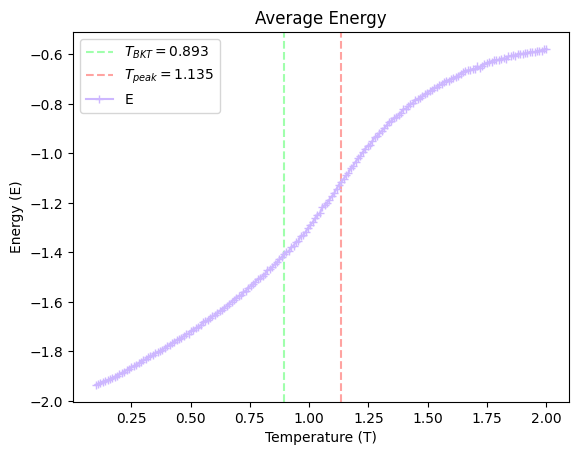

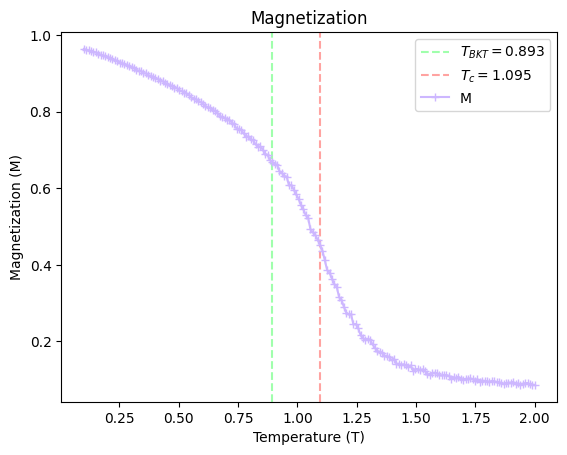

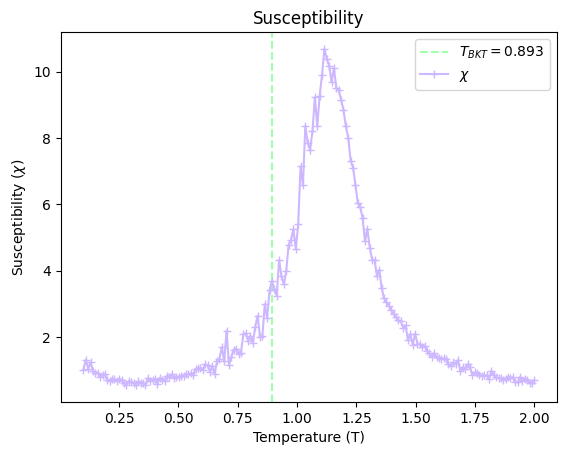

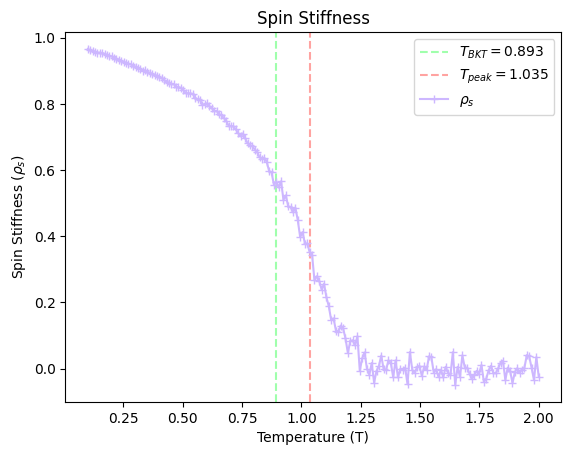

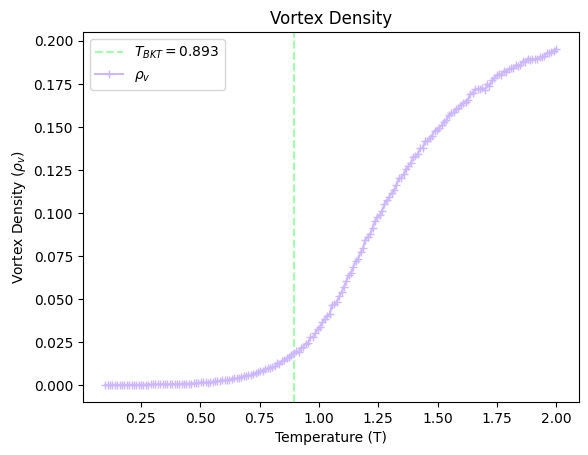

In [17]:
fm_energy_5_step = sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_magnetization_5_step = sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_5_step = sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    return_observation=True
)
fm_stiffness_5_step = sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_5_step = sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

### Compare the results between flow matching and Monte Carlo

In [18]:
mc_measure_results.keys()

dict_keys(['temperature', 'energy', 'specific_heat', 'magnetization', 'susceptibility', 'spin_stiffness', 'vortex_density'])

In [19]:
mc_temperature = mc_measure_results['temperature']
mc_energy = mc_measure_results['energy']
mc_magnetization = mc_measure_results['magnetization']
mc_susceptibility = mc_measure_results['susceptibility']
mc_stiffness = mc_measure_results['spin_stiffness']
mc_vortex_density = mc_measure_results['vortex_density']

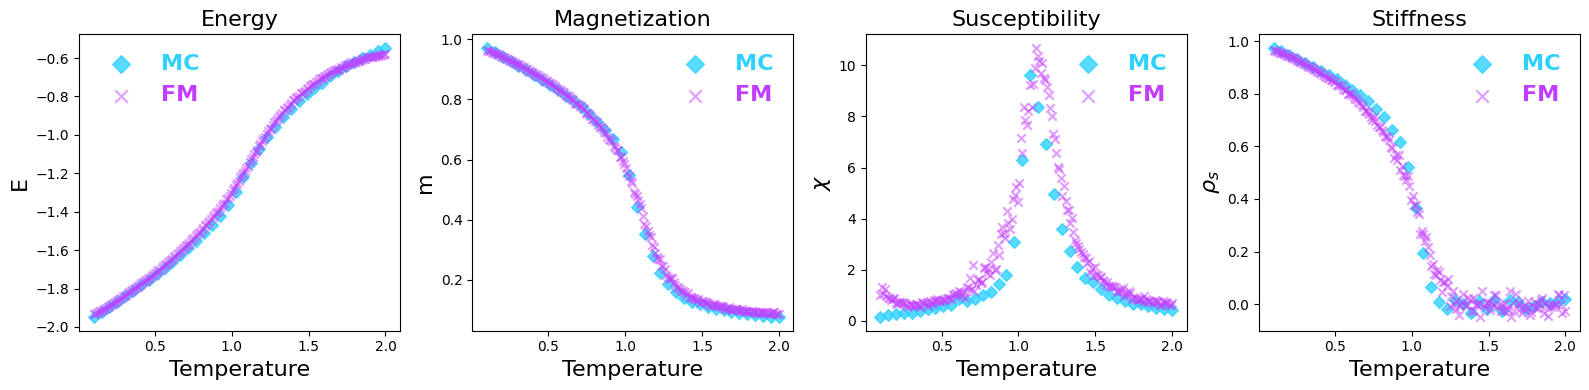

In [20]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF' 

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].scatter(mc_temperature, mc_energy, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0].scatter(Temp.cpu(), fm_energy_5_step, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[0].set_ylabel('E', fontsize=16)
ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_temperature, mc_magnetization, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1].scatter(Temp.cpu(), fm_magnetization_5_step, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[1].set_ylabel('m', fontsize=16)
ax[1].set_title('Magnetization', fontsize=16)

ax[2].scatter(mc_temperature, mc_susceptibility, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[2].scatter(Temp.cpu(), fm_susceptibility_5_step, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[2].set_ylabel(r'$\chi$', fontsize=16)
ax[2].set_title('Susceptibility', fontsize=16)

ax[3].scatter(mc_temperature, mc_stiffness, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[3].scatter(Temp.cpu(), fm_stiffness_5_step, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[3].set_ylabel(r'$\rho_s$', fontsize=16)
ax[3].set_title('Stiffness', fontsize=16)

for i in range(4):
    ax[i].set_xlabel('Temperature', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_color, fm_color],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

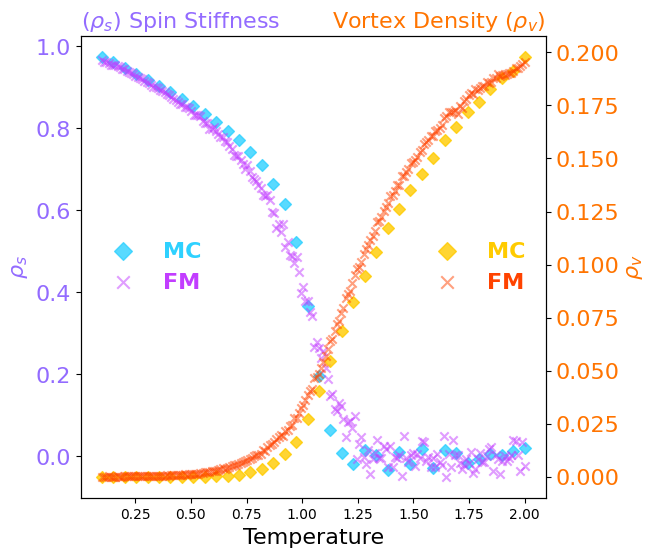

In [21]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

mc_stiffness_color = "#2ED1FF"
fm_stiffness_color = '#C23DFF' 

mc_vortex_density_color = "#FFCB00"
fm_vortex_density_color = "#FF4300"

stiffness_axis_color= "#936BFF"
vortex_axis_color = '#FF7400'


fig, ax1 = plt.subplots(figsize=(6, 6))
ax1.scatter(mc_temperature, mc_stiffness, marker='D', label='MC', color=mc_stiffness_color, alpha=0.8)
ax1.scatter(Temp.cpu(), fm_stiffness_5_step, marker='x', label='FM', color=fm_stiffness_color, alpha=0.5)
ax1.set_xlabel('Temperature', fontsize=16)
ax1.set_ylabel(r'$\rho_s$', fontsize=16, color=stiffness_axis_color)
ax1.set_title(r'($\rho_s$) Spin Stiffness', fontsize=16, color=stiffness_axis_color, loc='left')
ax1.tick_params(axis='y', labelsize=16, labelcolor=stiffness_axis_color)

ax1.legend(
        loc='center left',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_stiffness_color, fm_stiffness_color],
        markerscale=1.5,
        frameon=False
    )

ax2 = ax1.twinx()
ax2.scatter(mc_temperature, mc_vortex_density, marker='D', label='MC', color=mc_vortex_density_color, alpha=0.8)
ax2.scatter(Temp.cpu(), fm_vortex_density_5_step, marker='x', label='FM', color=fm_vortex_density_color, alpha=0.5)
ax2.set_ylabel(r'$\rho_v$', fontsize=16, color=vortex_axis_color)
ax2.set_title(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color, loc='right')
ax2.tick_params(axis='y', labelsize=16, labelcolor=vortex_axis_color)

ax2.legend(
        loc='center right',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_vortex_density_color, fm_vortex_density_color],
        markerscale=1.5,
        frameon=False
    )

plt.show()

### Sample with different steps and compare the results

#### Sample with 1 step

In [22]:
fmex.load_checkpoint(save_dir_root/f'checkpoints/checkpoint_epoch_{TOTAL_EPOCHS:04d}.pth')

num_steps = 1

torch.cuda.empty_cache()
sol_1_step = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
)
torch.cuda.empty_cache()


2025-06-23 18:39:34,823 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-06-23 18:39:34,823 - INFO - Loaded checkpoint from increase_sample_density_log\checkpoints\checkpoint_epoch_0010.pth. Last completed epoch: 10.
2025-06-23 18:39:34,824 - INFO - Training will resume from epoch 11.
2025-06-23 18:39:34,824 - INFO -   Last recorded average epoch loss: 1.4898
2025-06-23 18:39:34,825 - INFO -   Associated model params from checkpoint: {'in_channels': 1, 'out_channels': 1, 'model_channels': 32, 'channel_mult': (1, 2, 4), 'num_res_blocks': 1, 'dropout': 0.0, 'num_heads': 4, 'num_groups': 4, 'time_emb_dims': 16, 'cond_emb_dims': (16,), 'final_emb_dims': 64}
2025-06-23 18:39:34,828 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-06-23 18:39:34,828 - INFO - Starting sample generation (solving ODE)...
2025-06-23 18:39:34,829 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-06-23 18:39:34,829 - INFO -   Time Grid (Fixed Steps): 

In [23]:
sampler_xy.spins = sol_1_step
trash.append(sol_1_step)

fm_energy_1_step = sampler_xy.compute_average_energy().cpu()
fm_magnetization_1_step = sampler_xy.compute_magnetization().cpu()
fm_susceptibility_1_step = sampler_xy.compute_susceptibility().cpu()
fm_stiffness_1_step = sampler_xy.compute_spin_stiffness().cpu()

#### Sample with 3 step

In [24]:
num_steps = 3

torch.cuda.empty_cache()
sol_3_step = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
)
torch.cuda.empty_cache()

2025-06-23 18:40:40,884 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-06-23 18:40:40,885 - INFO - Starting sample generation (solving ODE)...
2025-06-23 18:40:40,885 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-06-23 18:40:40,886 - INFO -   Time Grid (Fixed Steps): [0.0, 0.3333333432674408, 0.6666666269302368, 1.0]
2025-06-23 18:40:40,887 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.1304347962141037, 0.375, 1.0]
2025-06-23 18:43:54,773 - INFO - Reshaped generated solutions tensor shape: torch.Size([190, 500, 24, 24])
2025-06-23 18:43:54,774 - INFO - Sample generation finished. Total samples: 95000.


In [25]:
sampler_xy.spins = sol_3_step
trash.append(sol_3_step)

fm_energy_3_step = sampler_xy.compute_average_energy().cpu()
fm_magnetization_3_step = sampler_xy.compute_magnetization().cpu()
fm_susceptibility_3_step = sampler_xy.compute_susceptibility().cpu()
fm_stiffness_3_step = sampler_xy.compute_spin_stiffness().cpu()

<Figure size 640x480 with 0 Axes>

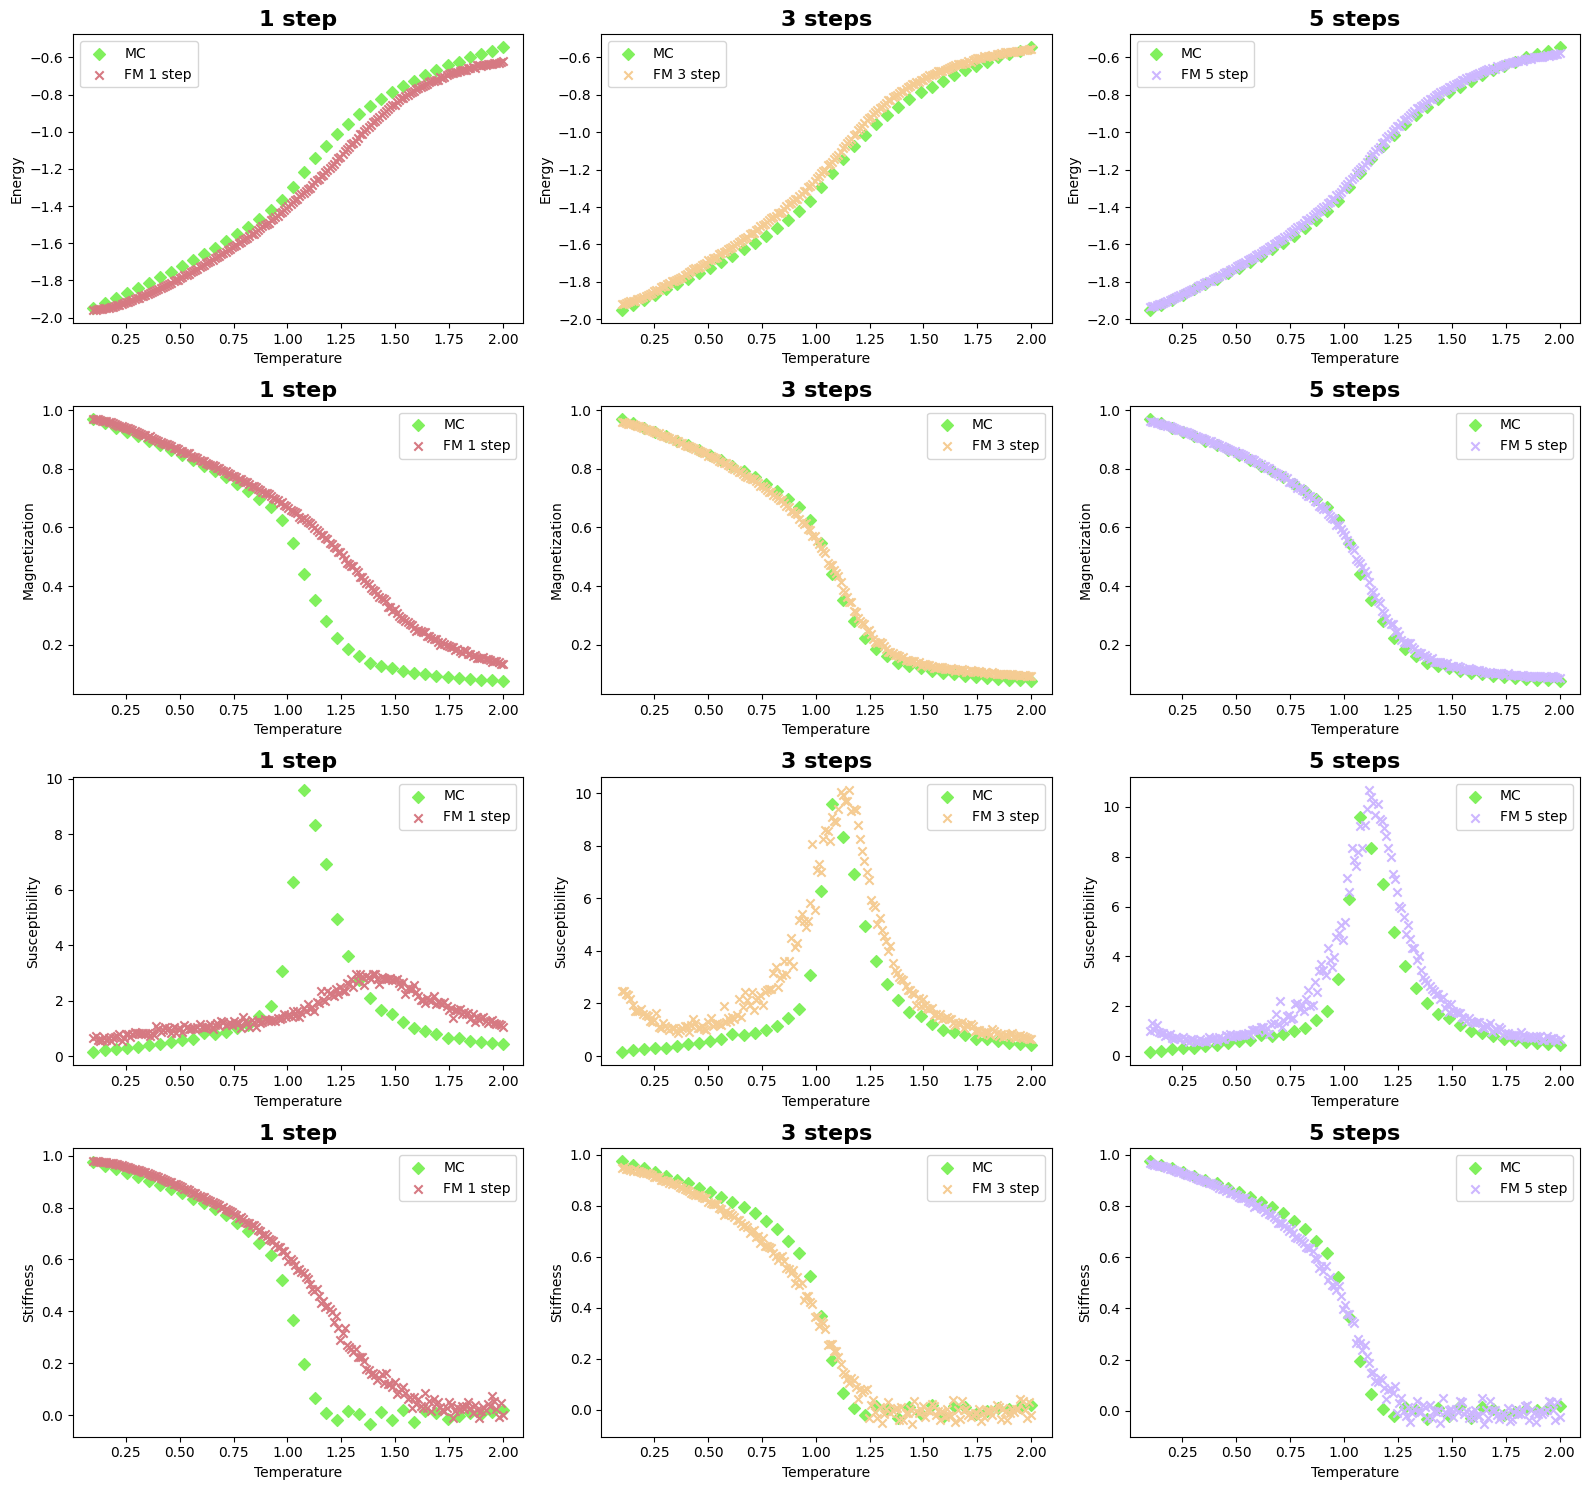

In [26]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

fig, ax = plt.subplots(4, 3, figsize=(16, 15))

for i in range(3):
    ax[0, i].scatter(mc_temperature, mc_energy, marker='D', label='MC', color="#81F05D")
    ax[0, i].set_ylabel('Energy')
    ax[1, i].scatter(mc_temperature, mc_magnetization, marker='D', label='MC', color="#81F05D")
    ax[1, i].set_ylabel('Magnetization')
    ax[2, i].scatter(mc_temperature, mc_susceptibility, marker='D', label='MC', color="#81F05D")
    ax[2, i].set_ylabel('Susceptibility')
    ax[3, i].scatter(mc_temperature, mc_stiffness, marker='D', label='MC', color="#81F05D")
    ax[3, i].set_ylabel('Stiffness')
    
ax[0, 0].scatter(Temp.cpu(), fm_energy_1_step, marker='x', label='FM 1 step', color='#D67982')
ax[0, 1].scatter(Temp.cpu(), fm_energy_3_step, marker='x', label='FM 3 step', color='#F5CC93')
ax[0, 2].scatter(Temp.cpu(), fm_energy_5_step, marker='x', label='FM 5 step', color='#CDB7FF')

ax[1, 0].scatter(Temp.cpu(), fm_magnetization_1_step, marker='x', label='FM 1 step', color='#D67982')
ax[1, 1].scatter(Temp.cpu(), fm_magnetization_3_step, marker='x', label='FM 3 step', color='#F5CC93')
ax[1, 2].scatter(Temp.cpu(), fm_magnetization_5_step, marker='x', label='FM 5 step', color='#CDB7FF')

ax[2, 0].scatter(Temp.cpu(), fm_susceptibility_1_step, marker='x', label='FM 1 step', color='#D67982')
ax[2, 1].scatter(Temp.cpu(), fm_susceptibility_3_step, marker='x', label='FM 3 step', color='#F5CC93')
ax[2, 2].scatter(Temp.cpu(), fm_susceptibility_5_step, marker='x', label='FM 5 step', color='#CDB7FF')

ax[3, 0].scatter(Temp.cpu(), fm_stiffness_1_step, marker='x', label='FM 1 step', color='#D67982')
ax[3, 1].scatter(Temp.cpu(), fm_stiffness_3_step, marker='x', label='FM 3 step', color='#F5CC93')
ax[3, 2].scatter(Temp.cpu(), fm_stiffness_5_step, marker='x', label='FM 5 step', color='#CDB7FF')

for i in range(4):
    for j in range(3):
        ax[i, j].set_xlabel('Temperature')
        
        if j == 0:
            ax[i, j].set_title(f'1 step', fontsize=16, fontweight='bold')
        else:
            ax[i, j].set_title(f'{2**j+1} steps', fontsize=16, fontweight='bold')
            
        ax[i, j].legend()
    

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

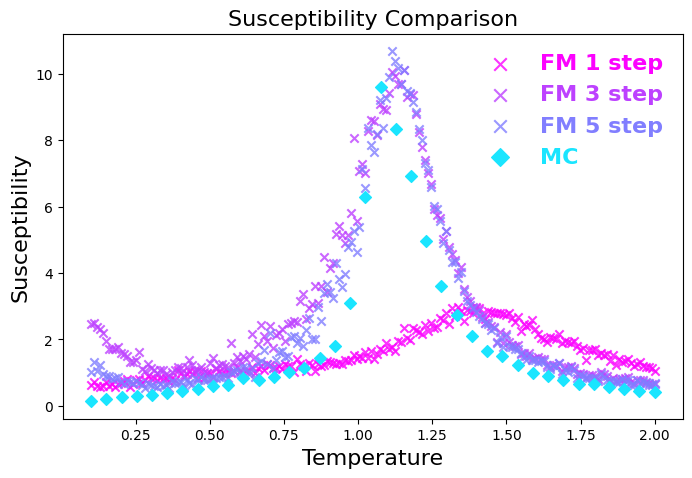

In [27]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

fig, ax = plt.subplots( figsize=(8, 5))

ax.scatter(Temp.cpu(), fm_susceptibility_1_step, marker='x', label='FM 1 step', color='#FC02FF', alpha=0.8)
ax.scatter(Temp.cpu(), fm_susceptibility_3_step, marker='x', label='FM 3 step', color='#BD41FF', alpha=0.8)
ax.scatter(Temp.cpu(), fm_susceptibility_5_step, marker='x', label='FM 5 step', color='#817EFF', alpha=0.8)
ax.scatter(mc_temperature, mc_susceptibility, marker='D', label='MC', color="#1AE5FF")
ax.set_xlabel('Temperature', fontsize=16)
ax.set_ylabel('Susceptibility', fontsize=16)
ax.set_title('Susceptibility Comparison', fontsize=16)
ax.legend(
    prop={'weight': 'bold', 'size': 16},
    labelcolor=['#FC02FF', '#BD41FF', '#817EFF', '#1AE5FF'],
    markerscale=1.5,
    frameon=False
)
plt.show()

In [28]:
trash.append(sampler_xy)
# pf.clear_cuda_cache(trash)
# trash = []
torch.cuda.empty_cache()